# Urban Heat Island Effect Changes

## Authors & Contributors

### Notebook
- Jean Iaquinta, University of Oslo (Norway), [@j34ni](https://github.com/j34ni)

### Contributors
- Anne Fouilloux, Simula Research Laboratory (Norway), [@annefou](https://github.com/annefou)

<p align="center">
    <a href="https://w3id.org/ro-id/d640e4aa-63bf-4aac-b579-eef79f1da470">
        <img alt="RoHub" src="https://img.shields.io/badge/RoHub-FAIR_Executable_Research_Object-2ea44f?logo=Open+Access&logoColor=blue">
    </a>
</p>

<div class="alert alert-info">
<i class="fa-question-circle fa" style="font-size: 22px;color:#666;"></i> Overview
    <br>
    <br>
    <b>Questions</b>
    <ul>
        <li>What is the Urban Heat Island?</li>
        <li>How do I compute the Urban Heat island effect?</li>
        <li>What data can I use to compute the Urban Heat Island Effect?</li>
        <li>How can I represent the Urban Heat Island effect on a plot?</li>
    </ul>
    <b>Objectives</b>
    <ul>
        <li>Learn about the Urban Heat Island</li>
        <li>Learn about Open Meteo Historical Weather Data and API</li>
        <li>Learn to compute and plot the Urban Heat Island Effect</li>
    </ul>
</div>

## Context

The term "Urban Heat Island" (UHI) effect describes the phenomenon where urban environments exhibit higher air temperatures than their rural counterparts, a difference that is especially pronounced at night. This effect arises from the greater capacity of urban materials and man-made structures, such as buildings and pavements, to absorb, store, and then re-radiate heat compared to natural landscapes.

First identified over two centuries ago, the UHI effect is subject of research to understand, measure, and mitigate its impacts on society, economic activities, and public health. Although traditionally the prerogative of specialists, the UHI is also attracting increasing interest among citizens. However, not all have the necessary technical expertise or infrastructure access to source relevant data (from in-situ measurements, satellite remote sensing, or numerical models), process it efficiently, synthesize it and interpret the changes over time or between different locations.

The UHI-Stream tool was specifically developed to bridge this gap and quickly analyze temperature differences between two points anywhere on Earth's by leveraging EGI compute and storage resources (owned by CESNET) and ERA5-Land reanalysis data (available from 1950, as part of the Copernicus Climate Change Service). The corresponding hourly 2m air temperatures are streamed from S3 buckets, processed on-the-fly and visualized as annual heat-maps or animations spanning user-defined time-frames.

Conveniently hosted on RoHub as a FAIR (Findable, Accessible, Interoperable, and Reusable) Executable Research Object, UHI-Stream is expected to be further converted into a Galaxy tool with a Graphical User Interface as part of the EuroScienceGateway project, potentially incorporating additional features to help users pinpoint representative urban and adjacent rural areas, or account for more grid cells.

In summary, UHI-Stream is poised to become a valuable asset in urban climatology studies, enabling easier identification of UHI patterns and estimating climate impacts on a regional scale. The tool’s versatility in analyzing any two geographic points enhances its usefulness beyond the mere urban-rural context, allowing for comparative analyses of temperature changes across diverse locales, regardless of their relationship.

### Data

We will be using [ERA5-Land HRES dataset](https://confluence.ecmwf.int/display/CKB/ERA5-Land%3A+data+documentation) from [Open Meteo Historical Weather](https://open-meteo.com/en/docs/historical-weather-api#start_date=1940-03-17).

The ERA5-Land HRES dataset has been produced at a resolution of 9 km, (~0.08°) and in a (octahedral) reduced Gaussian grid (represented as TCo1279).

:::{warning}

Note that to prevent discontinuities when IFS data is used instead of ERA5 data (~ from January 2017) one can specify which model is to be used with the parameter "models": "era5_land", for instance

:::

## Setup

This episode uses the following main Python packages:

- openmeteo-requests {cite:ps}`a-openmeteo-requests2023`
- pandas {cite:ps}`a-pandas-reback2020`

Please install these packages if not already available in your Python environment.

### Packages

In this episode, some Python packages are imported when we start to use them. However, for best software practices, we recommend you to install and import all the necessary libraries at the top of your Jupyter notebook.

#### Package Installation

In [1]:
! pip install openmeteo-requests
! pip install requests-cache retry-requests
! pip install cmcrameri

## Load Libraries

In [2]:
from cmcrameri import cm
import openmeteo_requests
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import pandas as pd
import requests_cache
import seaborn as sns
from retry_requests import retry
import hvplot.pandas

## Setup the Open-Meteo API client with cache and retry on error

In [3]:
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

## Define the period of interest 

In [4]:
start_year = 1950
end_year = 2023

## Define locations for which the 2m temperature is to be compared over the period of interest 

- For each Area of Interest, we define two distinct (but nearby) locations to compare in order to identify potential Urban Heat Island effects.

In [5]:
oslo_area = {
    "area" : "Norway",
    "urban" : "Oslo",
    "latitude_urban" : 59.92000036537046,
    "longitude_urban" : 10.700146410119512,
    "rural" : "Mortensrud",
    "latitude_rural" : 59.85344259770861,
    "longitude_rural" : 10.821229728045472,
    "time_zone" : "Europe/Oslo"
}

In [6]:
paris_area = {
    "area" : "Paris, France",
    "urban" : "Montsouris public park",
    "latitude_urban" : 48.82,
    "longitude_urban" : 2.33,
    "rural" : "Melun",
    "latitude_rural" : 48.61,
    "longitude_rural" : 2.67,
    "time_zone" : "Europe/Paris"
}

In [7]:
geirangerfjorden_area = {
    "area" : "Geirangerfjorden, Norway",
    "urban" : "Geiranger",
    "latitude_urban" : 62.09947881213586,
    "longitude_urban" : 7.20271411119387,
    "rural" : "Dalen Gaard",
    "latitude_rural" : 62.06916486996622,
    "longitude_rural" : 7.255376960289076,
    "time_zone" : "Europe/Oslo"
}

In [8]:
brazil_area = {
    "area" : "Brazil",
    "urban" : "Fortaleza",
    "latitude_urban" : -3.673056,
    "longitude_urban" : -38.942222,
    "rural" : "São Gonçalo do Amarante",
    "latitude_rural" : -3.795,
    "longitude_rural" : -38.558333,
    "time_zone" : "America/Sao_Paulo"
}

## Get the data from openmeteo archive <- time in GMT+0
- Here we fetch data for a given location.

In [9]:
class coordinates:
    def __init__(self, latitude, longitude):
        self.latitude = latitude
        self.longitude = longitude

In [10]:
def get_data(urban_coords, rural_coords, start_year, end_year):
    url = "https://archive-api.open-meteo.com/v1/archive"
    params = {
        "latitude": [urban_coords.latitude, rural_coords.latitude],
        "longitude": [urban_coords.longitude, rural_coords.longitude],
        "start_date": str(start_year) + "-01-01",
        "end_date": str(end_year) + "-12-31",
        "hourly": "temperature_2m",
        "timezone": "auto",    
        "models": "era5_land"
    }
    responses = openmeteo.weather_api(url, params=params)
    return responses

### Get Data for Brazil Area

In [11]:
area_params = brazil_area
urban_coords = coordinates( brazil_area["latitude_urban"], brazil_area["longitude_urban"])
rural_coords = coordinates( brazil_area["latitude_rural"], brazil_area["longitude_rural"])

responses = get_data(urban_coords, rural_coords, start_year, end_year)

## Compute Urban Heat Island

In [12]:
# First location - Urban
print(f"Urban location")
print(f"Coordinates {responses[0].Latitude()}°N {responses[0].Longitude()}°E")
print(f"Elevation {responses[0].Elevation()} m above sea level")
print(f"Timezone {responses[0].Timezone()} {responses[0].TimezoneAbbreviation()}")
print(f"Timezone difference to GMT+0 {responses[0].UtcOffsetSeconds()/3600.} hours")
print()

# Second location - Rural area
print(f"Rural location")
print(f"Coordinates {responses[1].Latitude()}°N {responses[1].Longitude()}°E")
print(f"Elevation {responses[1].Elevation()} m above sea level")
print(f"Timezone {responses[1].Timezone()} {responses[1].TimezoneAbbreviation()}")
print(f"Timezone difference to GMT+0 {responses[1].UtcOffsetSeconds()/3600.} hours")
print()

# Process hourly data
hourly = responses[0].Hourly()
hourly_temperature_2m_urban = responses[0].Hourly().Variables(0).ValuesAsNumpy()
hourly_temperature_2m_rural = responses[1].Hourly().Variables(0).ValuesAsNumpy()

hourly_data = {"date": pd.date_range(
	start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
	end = pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = hourly.Interval()),
	inclusive = "left"
)}
hourly_data["temperature_2m_urban-rural"] = hourly_temperature_2m_urban - hourly_temperature_2m_rural

hourly_dataframe = pd.DataFrame(data = hourly_data)

Urban location
Coordinates -3.6999969482421875°N -38.899993896484375°E
Elevation 34.0 m above sea level
Timezone b'America/Fortaleza' b'-03'
Timezone difference to GMT+0 -3.0 hours

Rural location
Coordinates -3.7999954223632812°N -38.59999084472656°E
Elevation 27.0 m above sea level
Timezone b'America/Fortaleza' b'-03'
Timezone difference to GMT+0 -3.0 hours



In [13]:
hourly_dataframe = hourly_dataframe.set_index("date")
hourly_dataframe

,temperature_2m_urban-rural
date,
1950-01-01 03:00:00+00:00,0.050001
1950-01-01 04:00:00+00:00,0.049999
1950-01-01 05:00:00+00:00,0.049999
1950-01-01 06:00:00+00:00,0.050001
1950-01-01 07:00:00+00:00,-0.099998
...,...
2023-12-31 22:00:00+00:00,0.049999
2023-12-31 23:00:00+00:00,0.049999
2024-01-01 00:00:00+00:00,0.000000


In [14]:
grouped = hourly_dataframe.groupby([hourly_dataframe.index.year, hourly_dataframe.index.month, hourly_dataframe.index.hour]).mean()

In [15]:
grouped

temperature_2m_urban-rural
date date date                            
1950 1    0                      -0.040000
          1                      -0.085000
          2                      -0.113334
          3                      -0.091935
          4                      -0.072581
...                                    ...
2023 12   22                      0.114516
          23                      0.017742
2024 1    0                       0.000000
          1                       0.000000
          2                      -0.049999

[21315 rows x 1 columns]

In [16]:
grouped.index = grouped.index.set_names('year', level=0)
grouped.index = grouped.index.set_names('month', level=1)
grouped.index = grouped.index.set_names('hour', level=2)

In [17]:
grouped.reset_index().set_index('year')

,month,hour,temperature_2m_urban-rural
year,,,
1950,1,0,-0.040000
1950,1,1,-0.085000
1950,1,2,-0.113334
1950,1,3,-0.091935
1950,1,4,-0.072581
...,...,...,...
2023,12,22,0.114516
2023,12,23,0.017742
2024,1,0,0.000000


In [18]:
hm = grouped.reset_index()

In [19]:
hm.min(), hm.max()

(year                          1950.000000
 month                            1.000000
 hour                             0.000000
 temperature_2m_urban-rural      -0.498333
 dtype: float64,
 year                          2024.000000
 month                           12.000000
 hour                            23.000000
 temperature_2m_urban-rural       1.382258
 dtype: float64)

In [20]:
# Adjust min & max for the plots
vmin = hm["temperature_2m_urban-rural"].min() - 0.1
vmax = hm["temperature_2m_urban-rural"].max() + 0.1

In [21]:
year = 1950
z = hm.loc[hm['year'] == year]
print(z.min(), z.max())

year                          1950.000000
month                            1.000000
hour                             0.000000
temperature_2m_urban-rural      -0.295161
dtype: float64 year                          1950.000000
month                           12.000000
hour                            23.000000
temperature_2m_urban-rural       1.183871
dtype: float64


In [22]:
# 1950 - Entire year
year = 1950
z = hm.loc[hm['year'] == year].pivot(index='month', columns='hour', values='temperature_2m_urban-rural')
z.loc[0:11].min().transpose().hvplot.line()

:Curve   [hour]   (0)

In [23]:
# 2023 - Entire year
year = 2023
z = hm.loc[hm['year'] == year].pivot(index='month', columns='hour', values='temperature_2m_urban-rural')
z.loc[0:11].mean().transpose().hvplot.line()

:Curve   [hour]   (0)

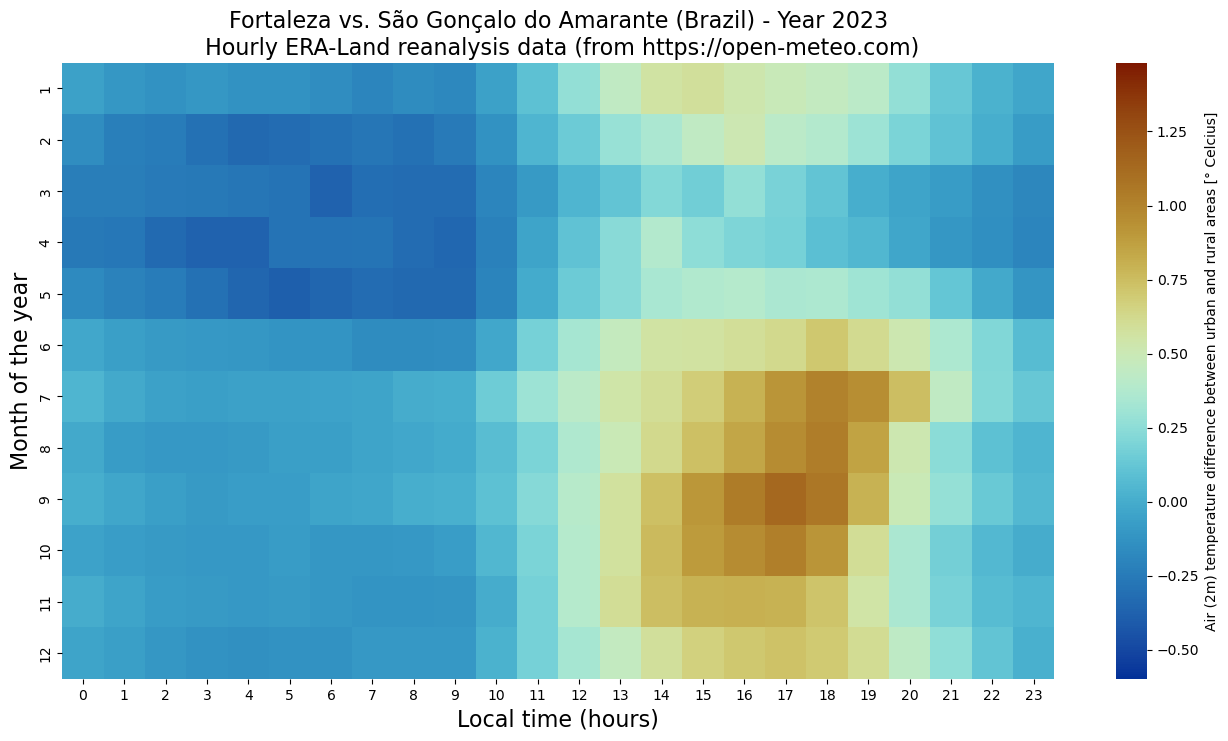

In [24]:
fig, ax = plt.subplots(figsize=(16,8)) 
ax = plt.subplot(1, 1, 1)
plt.title(area_params["urban"] + ' vs. ' + area_params["rural"] + ' (' + area_params["area"] + ') - Year '+ str(year) +'\n Hourly ERA-Land reanalysis data (from https://open-meteo.com)', fontsize=16)
sns.heatmap(z, cmap=cm.roma_r, vmin=vmin, vmax=vmax, cbar_kws={'label': 'Air (2m) temperature difference between urban and rural areas [° Celcius]'}, ax=ax)
ax.set_ylabel('Month of the year', fontsize=16)
ax.set_xlabel('Local time (hours)', fontsize=16)
plt.savefig('UHI_' + area_params["urban"] + '_' + str(year) + '.png')

In [25]:
years = hm['year'].unique()

In [26]:
def myheatmap(year, ax, start_year, area_params, hm):
    ax.clear()
    plt.clf()
    fig = plt.figure(1, figsize=[16,8])
    ax = plt.subplot(1, 1, 1)
    plt.title(area_params["urban"] + ' vs. ' + area_params["rural"] + ' (' + area_params["area"] + ') - Year '+ str(year  + start_year) +'\n Hourly ERA-Land reanalysis data (from https://open-meteo.com)', fontsize=16)
    z = hm.loc[hm['year'] == (year + start_year)].pivot(index='month', columns='hour', values='temperature_2m_urban-rural')
    ax = sns.heatmap(z, cmap=cm.roma_r, vmin=vmin, vmax=vmax, cbar_kws={'label': 'Air (2m) temperature difference between urban and rural areas [° Celcius]'})
    ax.set_ylabel('Month of the year', fontsize=16)
    ax.set_xlabel('Local time (hours)', fontsize=16)

## Create animation and save to HTML

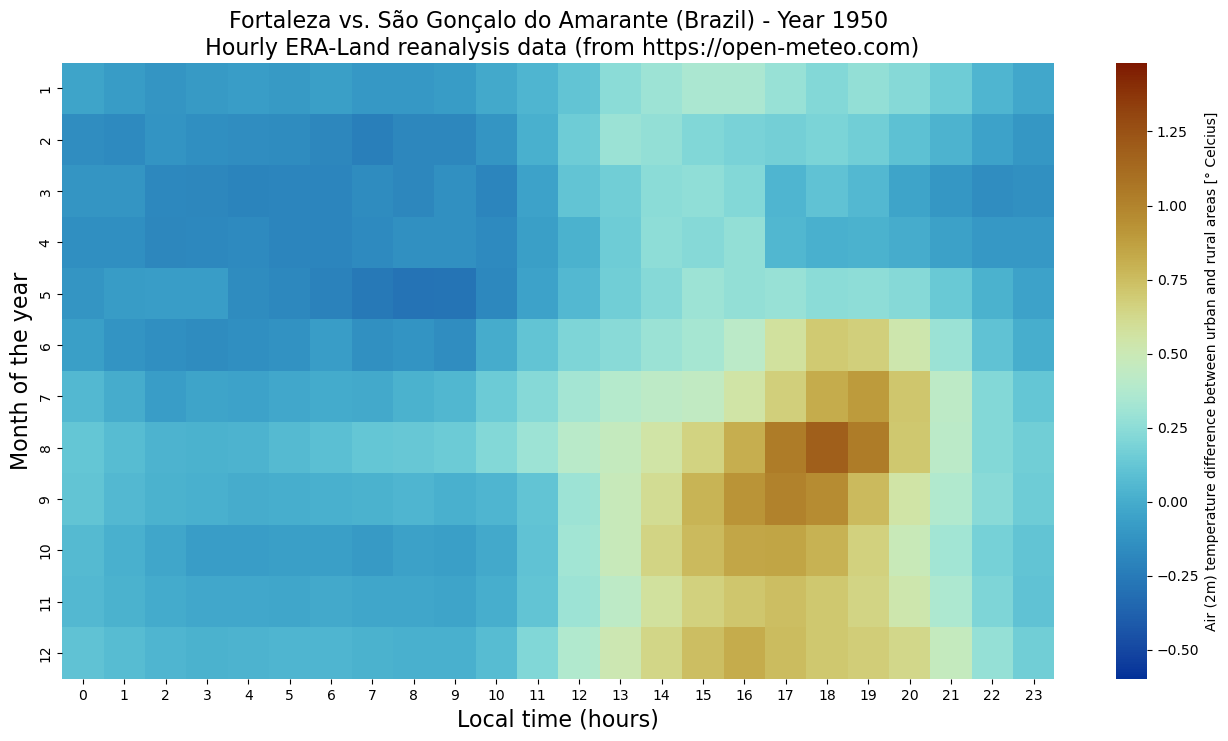

In [27]:
FFMpegWriter = animation.writers['ffmpeg']
metadata = dict(title='UHI in ' + area_params["urban"] + '(' + area_params["area"] + ')', artist='Jean Iaquinta', comment='ERA5-Land data from https://open-meteo.com')
writer = FFMpegWriter(fps=25, metadata=metadata)
fig = plt.figure(1, figsize=[16,8])
ax = plt.subplot(1, 1, 1)
ani = animation.FuncAnimation(fig, myheatmap, frames=range(end_year - start_year + 1), fargs=(ax, start_year, area_params, hm), interval=200)
vid = HTML(ani.to_html5_video())

In [29]:
with open('UHI_' + area_params["urban"] + '_' + str(start_year) + '-' + str(end_year) + '.html', 'w') as f:
    print(ani.to_html5_video(), file=f)

## Packages citation

```{bibliography}
:style: alpha
:filter: topic % "UHI" and topic % "package"
:keyprefix: a-
```